<a href="https://colab.research.google.com/github/R-Damanhuri/Review-Analysis-Access-KAI/blob/main/Customer_Review_Analysis_Access_by_KAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# GitHub Access

In [ ]:
from google.colab import userdata
git_token = userdata.get('git_token')

In [ ]:
username = "R-Damanhuri"
repository = "Review-Analysis-Access-KAI"

In [ ]:
!git config --global user.email "damans.remix2061@gmail.com"
!git config --global user.name username

In [ ]:
!git clone "https://{git_token}@github.com/{username}/{repository}.git"

Cloning into 'Review-Analysis-Access-KAI'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7 (delta 0), reused 4 (delta 0), pack-reused 0
Receiving objects: 100% (7/7), 2.94 MiB | 4.14 MiB/s, done.


In [ ]:
%cd {repository}

/content/Review-Analysis-Access-KAI


#Business Understanding

Rating Access by KAI di Google Play Store rendah. Terdapat review pengguna yang dapat digunakan untuk mencari tahu alasan di balik hal tersebut.

Business Objective:
*   Bagaimana tren yang terbentuk?
*   Mengapa pengguna memberi rating rendah?
*   Bagaimana cara pengembang menanggapi kejadian tersebut?




# Data Understanding

## Collect Initial Data

### Crawl Data

In [ ]:
!pip install google-play-scraper

In [ ]:
from google_play_scraper import app
from google_play_scraper import Sort, reviews, reviews_all

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import json
from time import sleep
from typing import List, Optional, Tuple

from google_play_scraper import Sort
from google_play_scraper.constants.element import ElementSpecs
from google_play_scraper.constants.regex import Regex
from google_play_scraper.constants.request import Formats
from google_play_scraper.utils.request import post

MAX_COUNT_EACH_FETCH = 199


class _ContinuationToken:
    __slots__ = (
        "token",
        "lang",
        "country",
        "sort",
        "count",
        "filter_score_with",
        "filter_device_with",
    )

    def __init__(
        self, token, lang, country, sort, count, filter_score_with, filter_device_with
    ):
        self.token = token
        self.lang = lang
        self.country = country
        self.sort = sort
        self.count = count
        self.filter_score_with = filter_score_with
        self.filter_device_with = filter_device_with


def _fetch_review_items(
    url: str,
    app_id: str,
    sort: int,
    count: int,
    filter_score_with: Optional[int],
    filter_device_with: Optional[int],
    pagination_token: Optional[str],
):
    dom = post(
        url,
        Formats.Reviews.build_body(
            app_id,
            sort,
            count,
            "null" if filter_score_with is None else filter_score_with,
            "null" if filter_device_with is None else filter_device_with,
            pagination_token,
        ),
        {"content-type": "application/x-www-form-urlencoded"},
    )
    match = json.loads(Regex.REVIEWS.findall(dom)[0])

    return json.loads(match[0][2])[0], json.loads(match[0][2])[-2][-1]


def reviews(
    app_id: str,
    lang: str = "en",
    country: str = "us",
    sort: Sort = Sort.NEWEST,
    count: int = 100,
    filter_score_with: int = None,
    filter_device_with: int = None,
    continuation_token: _ContinuationToken = None,
) -> Tuple[List[dict], _ContinuationToken]:
    sort = sort.value

    if continuation_token is not None:
        token = continuation_token.token

        if token is None:
            return (
                [],
                continuation_token,
            )

        lang = continuation_token.lang
        country = continuation_token.country
        sort = continuation_token.sort
        count = continuation_token.count
        filter_score_with = continuation_token.filter_score_with
        filter_device_with = continuation_token.filter_device_with
    else:
        token = None

    url = Formats.Reviews.build(lang=lang, country=country)

    _fetch_count = count

    result = []

    while True:
        if _fetch_count == 0:
            break

        if _fetch_count > MAX_COUNT_EACH_FETCH:
            _fetch_count = MAX_COUNT_EACH_FETCH

        try:
            review_items, token = _fetch_review_items(
                url,
                app_id,
                sort,
                _fetch_count,
                filter_score_with,
                filter_device_with,
                token,
            )
        except (TypeError, IndexError):
            if continuation_token != None:
              token = continuation_token.token
            continue

        for review in review_items:
            result.append(
                {
                    k: spec.extract_content(review)
                    for k, spec in ElementSpecs.Review.items()
                }
            )

        _fetch_count = count - len(result)

        if isinstance(token, list):
            token = None
            break

    return (
        result,
        _ContinuationToken(
            token, lang, country, sort, count, filter_score_with, filter_device_with
        ),
    )


def reviews_all(app_id: str, sleep_milliseconds: int = 0, **kwargs) -> list:
    kwargs.pop("count", None)
    kwargs.pop("continuation_token", None)

    continuation_token = None

    result = []

    while True:
        _result, continuation_token = reviews(
            app_id,
            count=MAX_COUNT_EACH_FETCH,
            continuation_token=continuation_token,
            **kwargs
        )

        result += _result

        if continuation_token.token is None:
            break

        if sleep_milliseconds:
            sleep(sleep_milliseconds / 1000)

    return result

In [ ]:
rvws, continuation_token = reviews(
    'com.kai.kaiticketing',
    lang='id',
    country='id',
    sort=Sort.NEWEST,
    count = 22000
)

In [ ]:
df = pd.DataFrame(np.array(rvws),columns=['review'])
df = df.join(pd.DataFrame(df.pop('review').tolist()))

In [ ]:
df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,c325a769-14d8-4d5e-942b-ddcf1439ce65,Arock Store,https://play-lh.googleusercontent.com/a/ACg8oc...,Pengembalian dana tiket lama betul aplikasi in...,1,0,None,2024-03-17 01:43:39,None,NaT,None
1,8c6e6774-c8a9-47ee-bfa2-355a64e6463e,Candra Dimuka,https://play-lh.googleusercontent.com/a-/ALV-U...,"Aduh tolong gimana ini ,mau jadi member basic ...",2,0,6.3.3,2024-03-17 01:27:53,None,NaT,6.3.3
2,21019e67-8fa9-45bb-8c30-08b52f7a2971,Rokhadin,https://play-lh.googleusercontent.com/a-/ALV-U...,Good.,5,0,6.3.3,2024-03-17 01:26:13,None,NaT,6.3.3
3,fea4dc6e-4f7d-4d3b-9f86-65691d96ce22,Ahmad Mukhidin,https://play-lh.googleusercontent.com/a/ACg8oc...,sangat mudah dan membantu,5,0,6.3.3,2024-03-17 01:21:24,None,NaT,6.3.3
4,4991dcc6-fe16-4d06-a86c-13d44a79605a,Rico Andrian,https://play-lh.googleusercontent.com/a-/ALV-U...,Setiap habis top up harus nunggu lama kurang m...,3,0,6.4.0,2024-03-17 00:38:48,None,NaT,6.4.0
...,...,...,...,...,...,...,...,...,...,...,...
21995,0aa52bbf-e77d-4086-b324-7f9852b2e8a6,Andri Yati,https://play-lh.googleusercontent.com/a-/ALV-U...,Saya kasih bintang 5 nih supaya di baca keluha...,5,0,None,2023-03-06 18:16:06,None,NaT,None
21996,7aa32ece-98d8-4077-acb0-a0cebe7240df,nazareth Juno,https://play-lh.googleusercontent.com/a/ACg8oc...,Aplikasi zampah.. Permintaan Time Out melulu !...,1,0,5.1.0,2023-03-06 18:15:39,None,NaT,5.1.0
21997,141fd41f-f0ea-4d3c-b0d9-dd1353a51eff,Galang Putra Pertama,https://play-lh.googleusercontent.com/a-/ALV-U...,Saban hari tiap taon server down,1,0,5.1.0,2023-03-06 18:15:24,None,NaT,5.1.0
21998,e3cda741-dbb0-45a4-b60a-f0908858a0c8,Abng Malik,https://play-lh.googleusercontent.com/a-/ALV-U...,Lemotnya,1,0,5.1.0,2023-03-06 18:12:48,None,NaT,5.1.0


In [ ]:
max(df['at'])

Timestamp('2024-03-17 01:43:39')

In [ ]:
min(df['at'])

Timestamp('2023-03-06 18:11:41')

In [ ]:
%mkdir data

In [ ]:
df.to_csv("data/kai_reviews.csv",sep=",")

### Store Data

In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	data/

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
!git add data/
!git commit -m "collect raw data"

[main 75e2b8c] collect raw data
 1 file changed, 22186 insertions(+)
 create mode 100644 data/kai_reviews.csv


In [ ]:
!git status

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


In [ ]:
!git push "https://{git_token}@github.com/{username}/{repository}.git"

Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (4/4), 2.94 MiB | 4.11 MiB/s, done.
Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/R-Damanhuri/Review-Analysis-Access-KAI.git
   aca7421..75e2b8c  main -> main


## Describe Data

In [ ]:
df_collected = pd.read_csv("data/kai_reviews.csv", index_col='Unnamed: 0')

In [ ]:
df_collected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22000 entries, 0 to 21999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              22000 non-null  object
 1   userName              22000 non-null  object
 2   userImage             22000 non-null  object
 3   content               22000 non-null  object
 4   score                 22000 non-null  int64 
 5   thumbsUpCount         22000 non-null  int64 
 6   reviewCreatedVersion  17445 non-null  object
 7   at                    22000 non-null  object
 8   replyContent          6964 non-null   object
 9   repliedAt             6964 non-null   object
 10  appVersion            17445 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.0+ MB


Atribut yang jelas akan digunakan:
*   content
*   score
*   thumbsUpCount
*   at
*   replyContent
*   repliedAt

Atribut yang perlu **dieksplorasi**, apakah redundan
*   reviewCreatedVersion
*   appVersion



In [ ]:
df_collected['at'] = pd.to_datetime(df_collected['at'])
df_collected['repliedAt'] = pd.to_datetime(df_collected['repliedAt'])

In [ ]:
df_collected.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,c325a769-14d8-4d5e-942b-ddcf1439ce65,Arock Store,https://play-lh.googleusercontent.com/a/ACg8oc...,Pengembalian dana tiket lama betul aplikasi in...,1,0,NaN,2024-03-17 01:43:39,NaN,NaT,NaN
1,8c6e6774-c8a9-47ee-bfa2-355a64e6463e,Candra Dimuka,https://play-lh.googleusercontent.com/a-/ALV-U...,"Aduh tolong gimana ini ,mau jadi member basic ...",2,0,6.3.3,2024-03-17 01:27:53,NaN,NaT,6.3.3
2,21019e67-8fa9-45bb-8c30-08b52f7a2971,Rokhadin,https://play-lh.googleusercontent.com/a-/ALV-U...,Good.,5,0,6.3.3,2024-03-17 01:26:13,NaN,NaT,6.3.3
3,fea4dc6e-4f7d-4d3b-9f86-65691d96ce22,Ahmad Mukhidin,https://play-lh.googleusercontent.com/a/ACg8oc...,sangat mudah dan membantu,5,0,6.3.3,2024-03-17 01:21:24,NaN,NaT,6.3.3
4,4991dcc6-fe16-4d06-a86c-13d44a79605a,Rico Andrian,https://play-lh.googleusercontent.com/a-/ALV-U...,Setiap habis top up harus nunggu lama kurang m...,3,0,6.4.0,2024-03-17 00:38:48,NaN,NaT,6.4.0


In [ ]:
df_collected.describe()

,score,thumbsUpCount
count,22000.000000,22000.000000
mean,1.713227,1.294727
std,1.321561,18.602208
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,5.000000,1285.000000


## Data Exploration

### Review Created Version dan App Version

In [ ]:
import re

def compare_versions(review_version, app_version):
  same_count = 0
  diff_count = 0
  rev_higher = 0
  app_higher = 0

  for rev, app in zip (review_version,app_version):
    if rev == app:
      same_count += 1
    else:
      diff_count += 1

      review_nums = [int(num) for num in re.findall(r'\d+', str(rev))]
      app_nums = [int(num) for num in re.findall(r'\d+', str(app))]

      if review_nums > app_nums:
        rev_higher += 1
      else:
        app_higher += 1
  return same_count, diff_count, rev_higher, app_higher

In [ ]:
same_count, diff_count, rev_higher, app_higher = compare_versions(df_collected['reviewCreatedVersion'], df_collected['appVersion'])

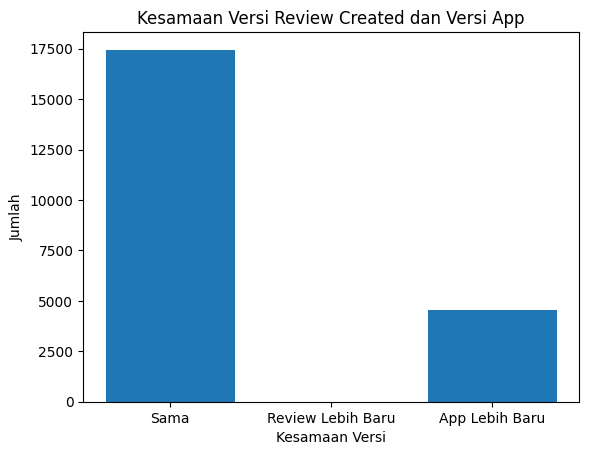

In [ ]:
import matplotlib.pyplot as plt

labels = ['Sama', 'Review Lebih Baru', 'App Lebih Baru']
counts = [same_count, rev_higher, app_higher]

plt.bar(labels, counts)
plt.xlabel('Kesamaan Versi')
plt.ylabel('Jumlah')
plt.title('Kesamaan Versi Review Created dan Versi App')
plt.show()

*   reviewCreatedVersion dan appVersion dominan bernilai sama
*   apabila berbeda, appVersion selalu yang lebih baru versinya daripada reviewCreatedVersion

*   **reviewCreatedVersion digunakan**; appVersion tidak



### Thumbs Up Count

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
top_thumbs = df_collected.sort_values(by='thumbsUpCount', ascending=False)[['content','thumbsUpCount']][:5]
top_thumbs

,content,thumbsUpCount
7518,"Aplikasi KAI Acces sebelumnya lebih simple dan jelas, digunakan langsung lancar sesuai yg dituju. Setelah diupgrade dg yang baru, hanya untuk mengecek posisi kereta saja tidak bisa tampil tidak bisa diklik???Lebih baik kembalikan seperti aplikasi KAI yg AWAL, lancar digunakan, tampilan juga jelas, huruf2nya juga besar. Aplikasi Kai terbaru Tidak muncul untuk cek posisi krl. 👎",1285
15317,"Ternyata banyak yang kecewa dgn KAI ACCESS yang sekarang, termasuk saya. Pilih kereta antar kota hanya ada pilihan stasiun populer saja, dicari stasiun lain malah tidak muncul. Ketika kita cari stasiun tujuan malah stak tidak ada pencarian otomatis. Haduuhhhh... Mana lemot lagi responnya untuk aplikasi yang sekarang. Kembalikan lagi KAI ACCESS yang dulu. Simple, respon, gampang diakses.",912
3316,"Lebih suka versi lama, versi baru tidak mempermudah tpi malah mempersulit, udah ditungguin sampai jam 12 MLM setiap beberapa menit sekali saya coba tetep tidak mau muncul tiketnya, sampai saya tunggu sampai jam set 1 eh malah sudah habis, mengecewakan sekali. Lebih sulit. Hp udah rela di refresh sampai pakai paket data atau WiFi tetep ndakbisa. Udah komplain gak ada perubahan. Miris kecewa",857
7021,"Min ini kenapa ga bs login ya. Jaringan internet wifi dan ponsel keduanya stabil dan lancar. Buat YouTube ga masalah. Hamya pas dipake buat login ga bs. Tolong diperbaiki. Kmudian tolong ketika menampilkan hasil search kereta jgn kayak menipu dong harganya. Hasil search harganya rendah, tp ternyata stlh di klik drop down/detail...yg harga tertera sdh habis, munclnya harga yg lbh mahal. Tolong dikembalikan saja ke settingan awal.",724
15749,"Bagusan aplikasi lama. Pilihan reduksi tidak muncul. Dari segi visualisasi ,membagongkan tdk enak dilihat dan sulit dipahami. User interface tuh jangan ramai banget warnanya. user suka yg simpel. Apakah sblm launching tdk di uji dan analisis dulu ke user sampel. Balik kayak yg lama aja, simpel. Kl pun mau tambah fungsi, ya jangan diubah tampilannya semua.",490


General Reason: Penurunan kualitas usai upgrade versi <br>
Specific reason: Disfungsi fitur cek posisi KRL, pilihan stasiun tidak lengkap, respons aplikasi lama, gagal login, antarmuka sulit dipahami

In [ ]:
pd.reset_option('display.max_colwidth')

### Score

**Banyak Data Berdasarkan Skor**

In [ ]:
df_collected['score'].value_counts().sort_index()

1    15618
2     2351
3     1127
4      530
5     2374
Name: score, dtype: int64

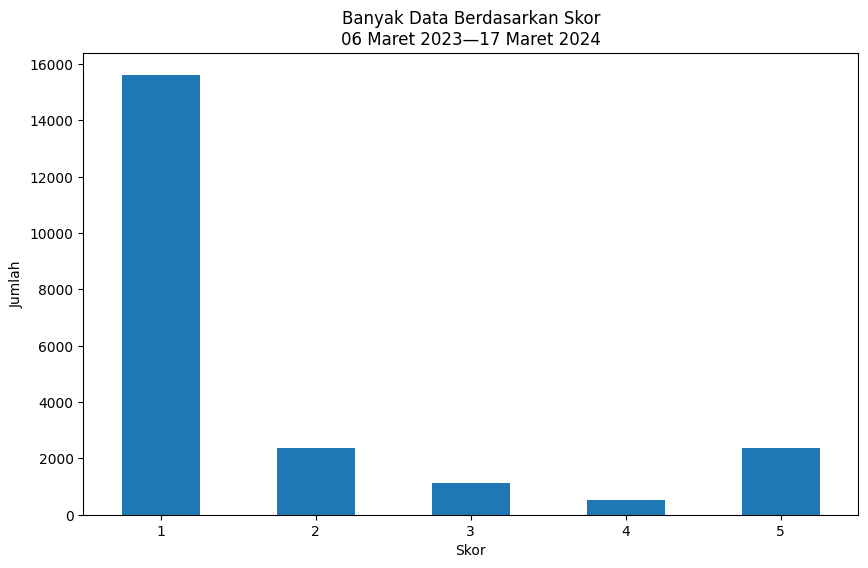

In [ ]:
plt.figure(figsize=(10, 6))
df_collected['score'].value_counts().sort_index().plot(kind='bar')
plt.title('Banyak Data Berdasarkan Skor\n06 Maret 2023—17 Maret 2024')
plt.xlabel('Skor')
plt.ylabel('Jumlah')
plt.xticks(rotation=360)
plt.show()

**Banyak Data Berdasarkan Tanggal dan Skor**

In [ ]:
score_counts_by_date = df_collected.groupby([df_collected['at'].dt.date, 'score']).size().unstack(fill_value=0)

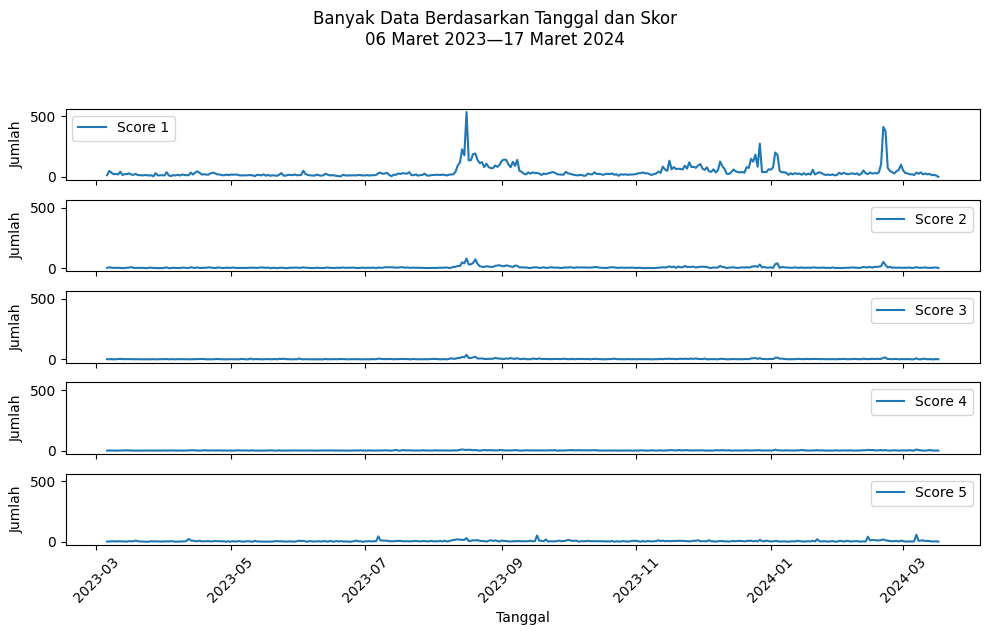

In [ ]:
fig, axs = plt.subplots(nrows=len(score_counts_by_date.columns), ncols=1, figsize=(10, 6), sharex=True, sharey=True)

# Plot garis untuk setiap skor
for i, (score, counts) in enumerate(score_counts_by_date.items()):
    axs[i].plot(score_counts_by_date.index, counts, label=f'Score {score}')
    axs[i].set_ylabel('Jumlah')
    axs[i].legend()

# Atur judul
plt.suptitle('Banyak Data Berdasarkan Tanggal dan Skor\n06 Maret 2023—17 Maret 2024', y=1.05)
plt.xlabel('Tanggal')
plt.xticks(rotation=45)

# Tampilkan plot
plt.tight_layout()
plt.show()

In [ ]:
max_score_dates = score_counts_by_date.idxmax()

print(max_score_dates)

score
1    2023-08-16
2    2023-08-16
3    2023-08-16
4    2023-08-14
5    2024-03-07
dtype: object


**Rata-Rata Skor Harian**

In [ ]:
import matplotlib.pyplot as plt

# Kelompokkan data berdasarkan hari dan hitung rata-rata skor per hari
df_daily_avg = df_collected.groupby(df_collected['at'].dt.date)['score'].mean().reset_index()
df_daily_avg['score'] = df_daily_avg['score'].round(2)

In [ ]:
df_daily_avg

,at,score
0,2023-03-06,1.70
1,2023-03-07,1.34
2,2023-03-08,1.60
3,2023-03-09,1.76
4,2023-03-10,1.52
...,...,...
373,2024-03-13,2.12
374,2024-03-14,2.00
375,2024-03-15,1.68
376,2024-03-16,2.25


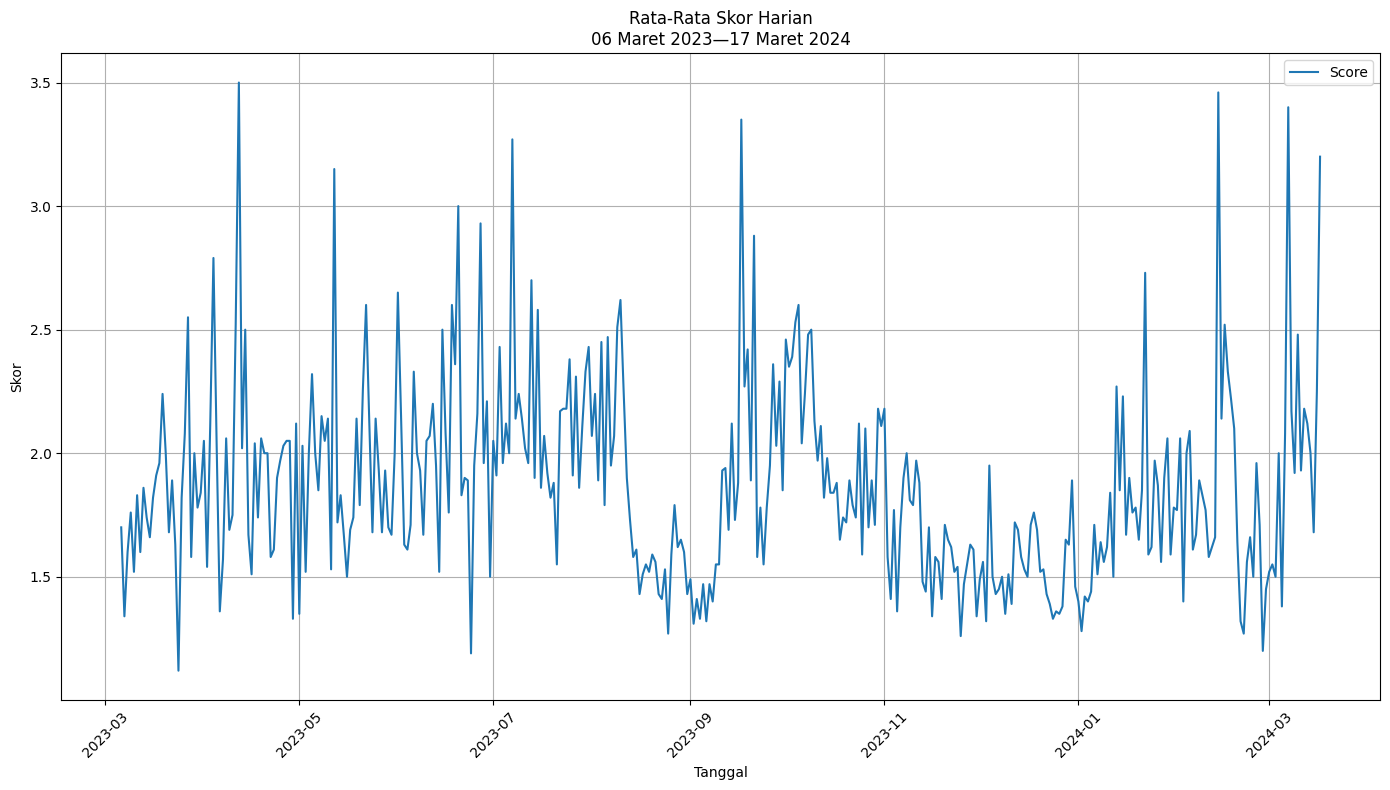

In [ ]:
# Membuat plot garis
plt.figure(figsize=(14, 8))
plt.plot(df_daily_avg['at'], df_daily_avg['score'], label=f'Score')

plt.title('Rata-Rata Skor Harian\n06 Maret 2023—17 Maret 2024')
plt.xlabel('Tanggal')
plt.ylabel('Skor')
plt.grid(True)
plt.xticks(rotation=45)  # Rotasi label sumbu x untuk memperjelas
plt.legend()
plt.tight_layout()
plt.show()

Plot terlalu fluktuatif sehingga perlu menggunakan Moving Average

**Moving Average dan Variance**

In [ ]:
# Menghitung moving average (misalnya, moving average 30 hari)
window = 30
df_daily_avg['moving_avg'] = df_daily_avg['score'].rolling(window=window).mean()

In [ ]:
std = df_daily_avg['score'].rolling(window=30).std()
df_daily_avg['upper'] = df_daily_avg['moving_avg'] + (2 * std)
df_daily_avg['lower'] = df_daily_avg['moving_avg'] - (2 * std)

In [ ]:
df_daily_avg

,at,score,moving_avg,upper,lower
0,2023-03-06,1.70,NaN,NaN,NaN
1,2023-03-07,1.34,NaN,NaN,NaN
2,2023-03-08,1.60,NaN,NaN,NaN
3,2023-03-09,1.76,NaN,NaN,NaN
4,2023-03-10,1.52,NaN,NaN,NaN
...,...,...,...,...,...
373,2024-03-13,2.12,1.931000,3.021718,0.840282
374,2024-03-14,2.00,1.942333,3.028455,0.856212
375,2024-03-15,1.68,1.883000,2.808682,0.957318
376,2024-03-16,2.25,1.886667,2.817418,0.955915


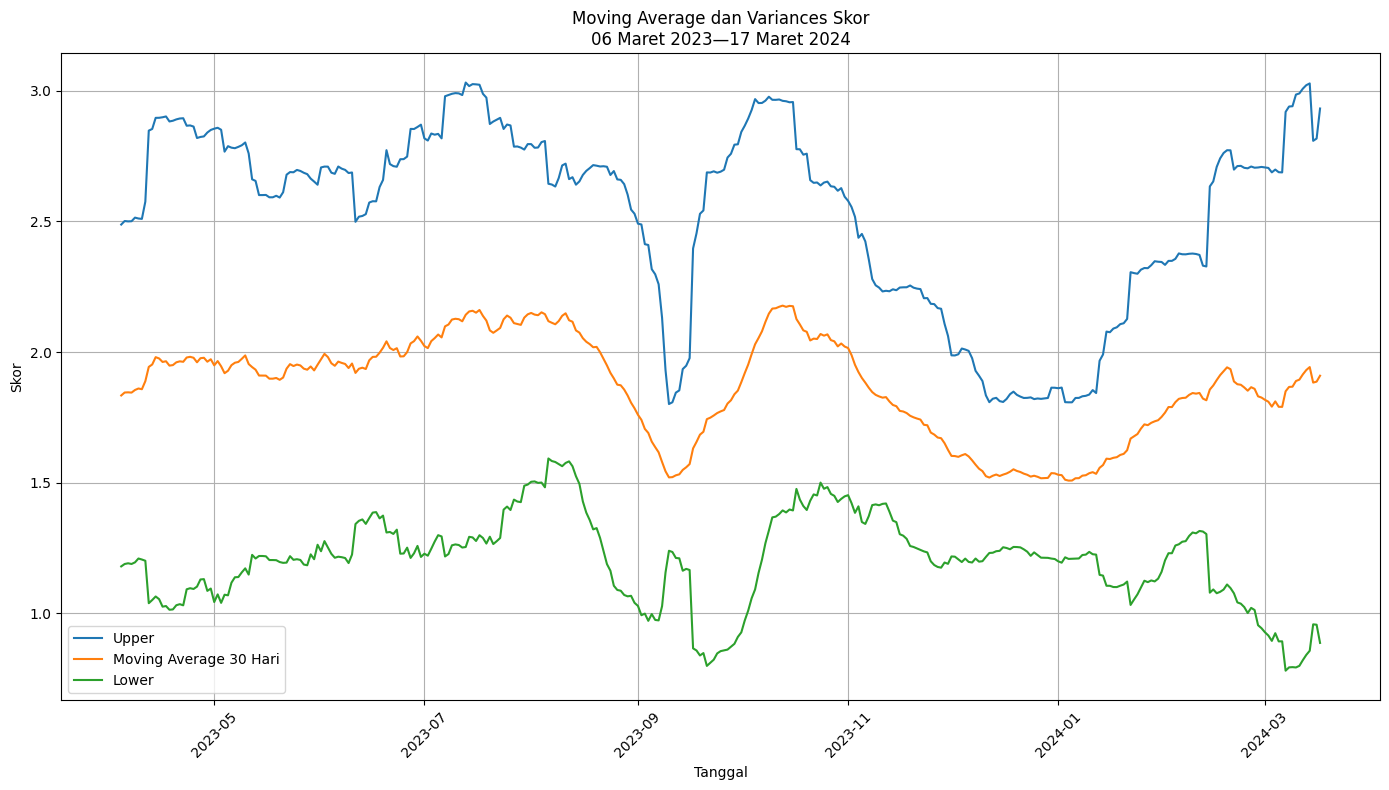

In [ ]:
# Membuat plot garis
plt.figure(figsize=(14, 8))
plt.plot(df_daily_avg['at'], df_daily_avg['upper'], label=f'Upper')
plt.plot(df_daily_avg['at'], df_daily_avg['moving_avg'], label=f'Moving Average {window} Hari')
plt.plot(df_daily_avg['at'], df_daily_avg['lower'], label=f'Lower')

plt.title('Moving Average dan Variances Skor\n06 Maret 2023—17 Maret 2024')
plt.xlabel('Tanggal')
plt.ylabel('Skor')
plt.grid(True)
plt.xticks(rotation=45)  # Rotasi label sumbu x untuk memperjelas
plt.legend()
plt.tight_layout()
plt.show()

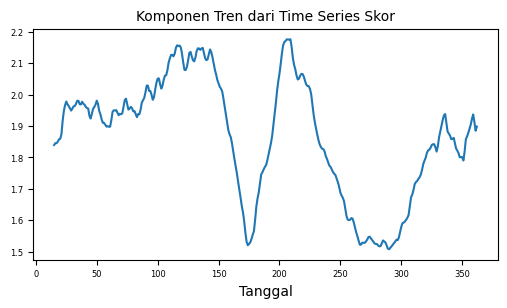

In [ ]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(df_daily_avg['score'], period=30)

trend = decomposition.trend
ax = trend.plot(figsize=(6, 3), fontsize=6)
ax.set_xlabel('Tanggal', fontsize=10)
ax.set_title('Komponen Tren dari Time Series Skor', fontsize=10)
plt.show()

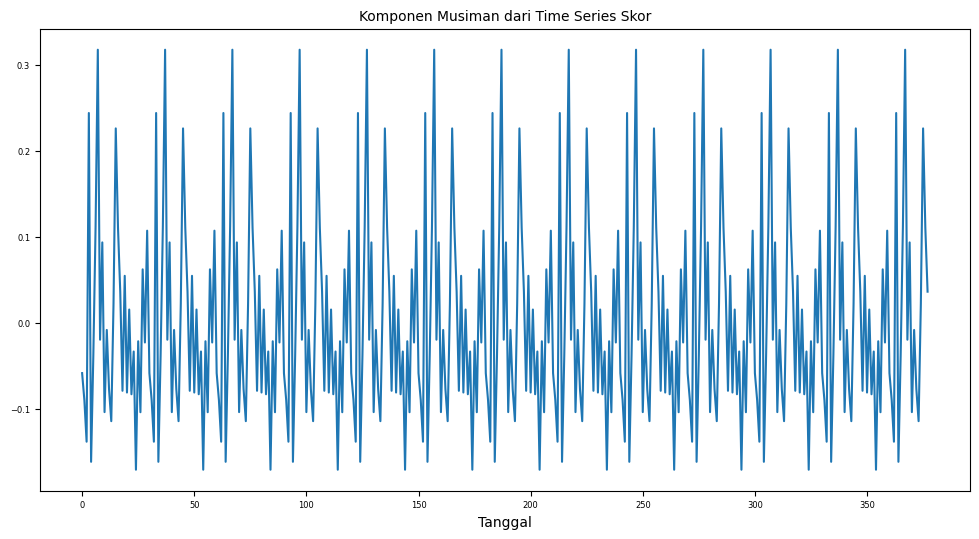

In [ ]:
seasonal = decomposition.seasonal
ax = seasonal.plot(figsize=(12, 6), fontsize=6)
ax.set_xlabel('Tanggal', fontsize=10)
ax.set_title('Komponen Musiman dari Time Series Skor', fontsize=10)
plt.show()

**Banyak Data Berdasarkan Bulan-Tahun**

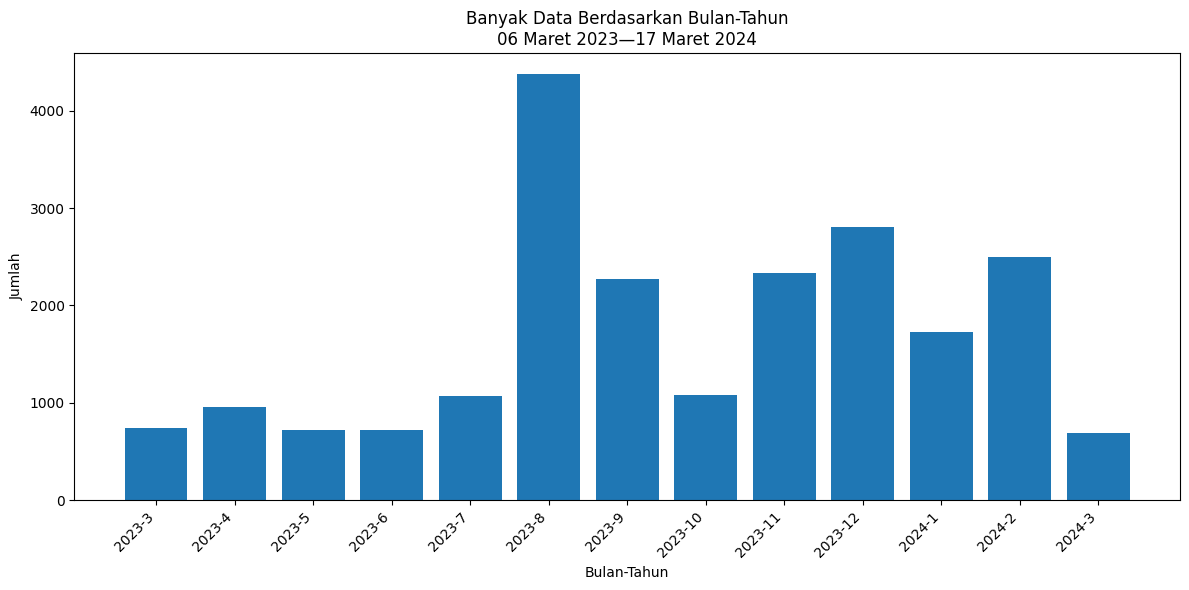

In [ ]:
# Ekstrak bulan dan tahun dari kolom 'at'
df_collected['Month'] = df_collected['at'].dt.month
df_collected['Year'] = df_collected['at'].dt.year

# Hitung frekuensi kombinasi bulan-tahun
count_data = df_collected.groupby(['Year', 'Month']).size().reset_index(name='Count')

# Membuat countplot dengan matplotlib
plt.figure(figsize=(12, 6))
plt.bar(count_data.index, count_data['Count'])
plt.title('Banyak Data Berdasarkan Bulan-Tahun\n06 Maret 2023—17 Maret 2024')
plt.xlabel('Bulan-Tahun')
plt.ylabel('Jumlah')
plt.xticks(ticks=range(len(count_data)), labels=[f"{year}-{month}" for year, month in zip(count_data['Year'], count_data['Month'])], rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

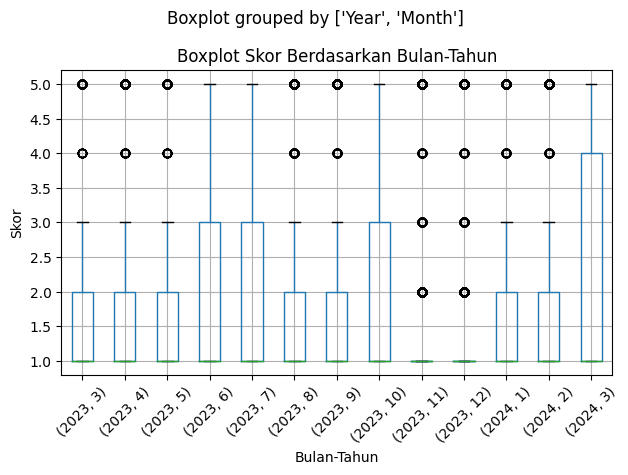

In [ ]:
# Membuat boxplot
plt.figure(figsize=(12, 6))
df_collected.boxplot(column='score', by=['Year', 'Month'])
plt.title('Boxplot Skor Berdasarkan Bulan-Tahun')
plt.xlabel('Bulan-Tahun')
plt.ylabel('Skor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Banyak Data Berdasarkan Skor dan Bulan-Tahun**

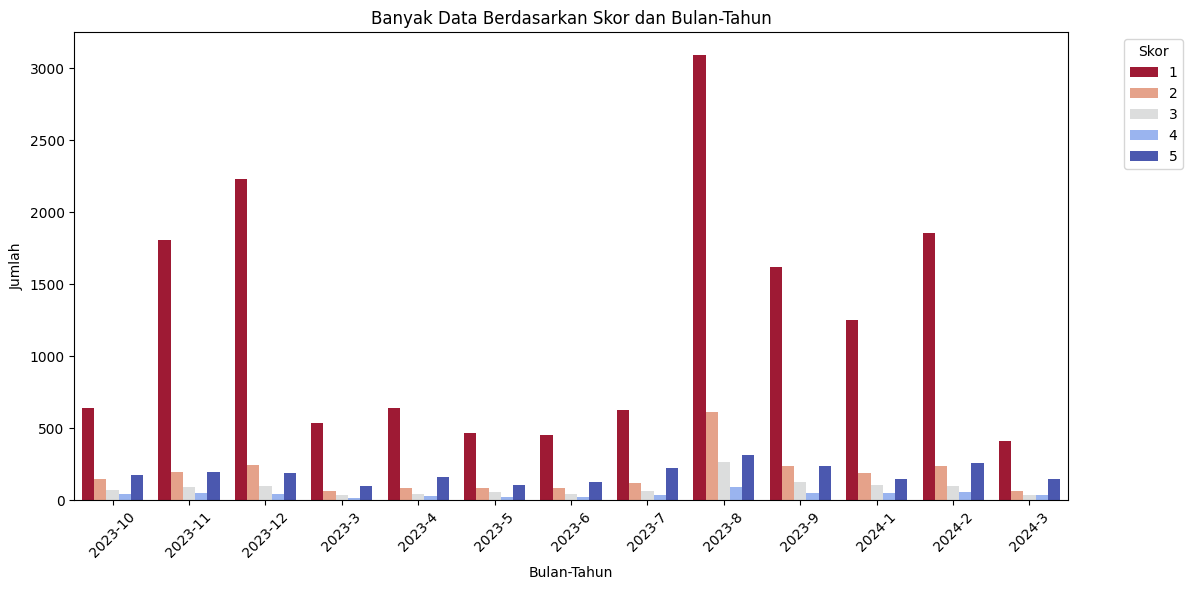

In [ ]:
import seaborn as sns

# Menggabungkan kolom 'Year' dan 'Month' menjadi satu kolom baru 'Year_Month'
df_collected['Year_Month'] = df_collected['Year'].astype(str) + '-' + df_collected['Month'].astype(str)

# Kelompokkan data berdasarkan bulan, tahun, dan skor, dan hitung jumlah kemunculan tiap skor
monthly_score_counts = df_collected.groupby(['Year_Month', 'score']).size().reset_index(name='count')

# Membuat barplot untuk setiap bulan-tahun dengan skor sebagai hue
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_score_counts, x='Year_Month', y='count', hue='score', palette='coolwarm_r')
plt.title('Banyak Data Berdasarkan Skor dan Bulan-Tahun')
plt.xlabel('Bulan-Tahun')
plt.ylabel('Jumlah')
plt.legend(title='Skor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Reply Content

In [ ]:
nan_count = df_collected['replyContent'].isna().sum()
print(nan_count)
non_nan_count = df_collected['replyContent'].notna().sum()
print(non_nan_count)

15036
6964


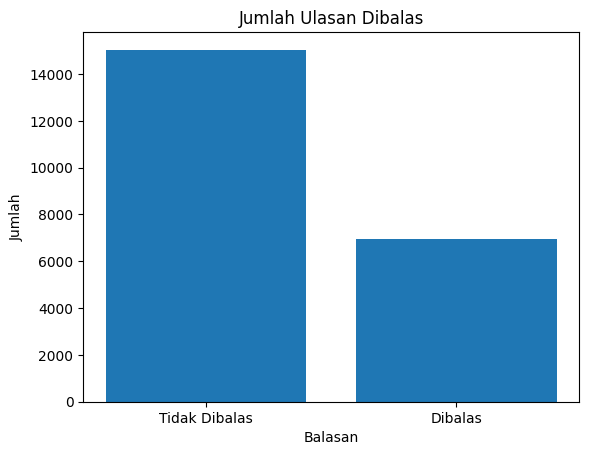

In [ ]:
nan_count = df_collected['replyContent'].isna().sum()
non_nan_count = df_collected['replyContent'].notna().sum()

# Membuat barplot
plt.bar(['Tidak Dibalas', 'Dibalas'], [nan_count, non_nan_count])
plt.title('Jumlah Ulasan Dibalas')
plt.xlabel('Balasan')
plt.ylabel('Jumlah')
plt.show()

In [ ]:
df_replied = df_collected[df_collected['replyContent'].notna()].copy()

In [ ]:
# Buat mapping untuk mengganti jumlah kemunculan tertentu menjadi label kategori yang sesuai
count_mapping = {
    '1 Ulasan': [1],
    '2-10 Ulasan': range(2, 11),
    '11-100 Ulasan': range(11, 101),
    '101-500 Ulasan': range(101, 501),
    '>500 Ulasan': range(501, df_replied['replyContent'].value_counts().max() + 1)
}

df_replied['freq_used'] = '1 Ulasan'
for label, count_range in count_mapping.items():
    df_replied.loc[df_replied['replyContent'].map(df_replied['replyContent'].value_counts()).isin(count_range), 'freq_used'] = label

In [ ]:
df_replied['freq_used'].value_counts()

101-500 Ulasan    2169
1 Ulasan          1451
>500 Ulasan       1403
11-100 Ulasan     1373
2-10 Ulasan        568
Name: freq_used, dtype: int64

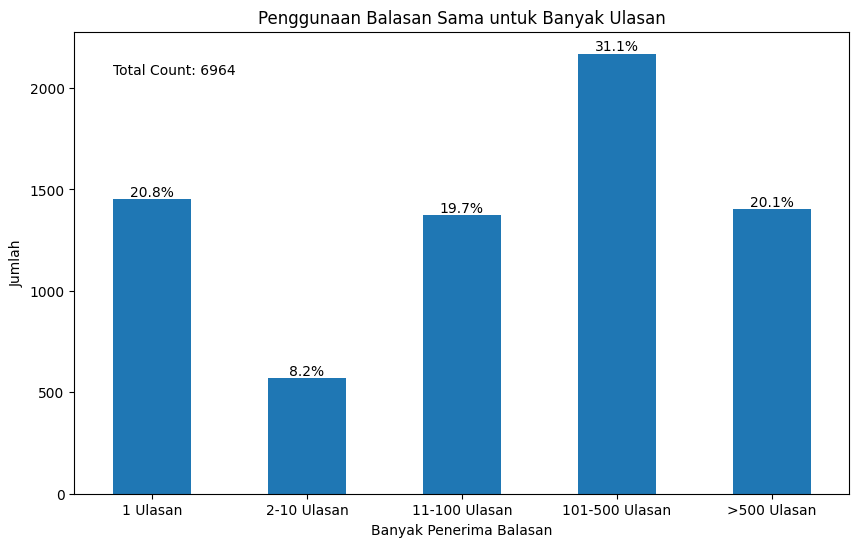

In [ ]:
reply_content_counts = df_replied['freq_used'].value_counts()

custom_order = ['1 Ulasan', '2-10 Ulasan', '11-100 Ulasan', '101-500 Ulasan', '>500 Ulasan']
reply_content_counts = reply_content_counts.reindex(custom_order)

rep_count = reply_content_counts.sum()
percentages = (reply_content_counts / rep_count) * 100

# Membuat barplot dengan urutan indeks yang sudah disesuaikan
plt.figure(figsize=(10, 6))
reply_content_counts.plot(kind='bar')
plt.title('Penggunaan Balasan Sama untuk Banyak Ulasan')
plt.xlabel('Banyak Penerima Balasan')
plt.ylabel('Jumlah')
plt.xticks(rotation=360)  # Atur rotasi label sumbu-x

# Menambahkan label persentase di atas setiap bar
for i, v in enumerate(reply_content_counts):
    plt.text(i, v + 15, f'{percentages[i]:.1f}%', ha='center')

plt.text(-0.25, max(reply_content_counts)-100, f'Total Count: {rep_count}', ha='left')

plt.show()

### Replied At

In [ ]:
# Hitung selisih waktu antara kedua kolom
df_replied['time_difference'] = df_replied['repliedAt'] - df_replied['at']

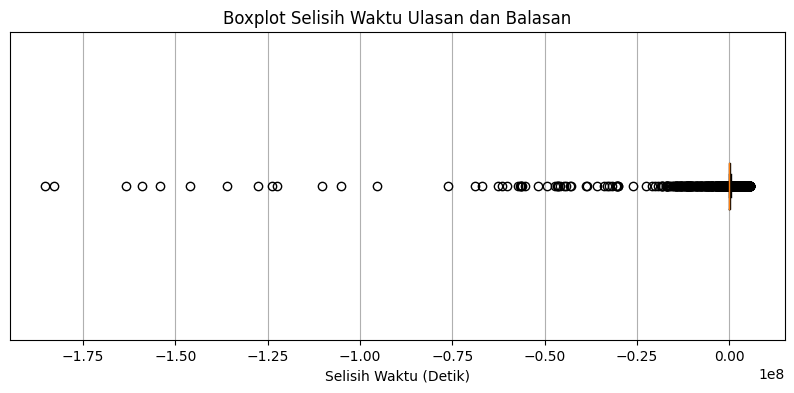

In [ ]:
# Konversi selisih waktu ke dalam satuan detik
time_difference_seconds = df_replied['time_difference'].dt.total_seconds()

# Plot boxplot selisih waktu
plt.figure(figsize=(10, 4))
plt.boxplot(time_difference_seconds, vert=False)
plt.title('Boxplot Selisih Waktu Ulasan dan Balasan')
plt.xlabel('Selisih Waktu (Detik)')
plt.yticks([])
plt.grid(axis='x')
plt.show()

Anomali terdeteksi berupa selisih waktu negatif atau tanggal balasan lebih dahulu daripada tanggal ulasan.

In [ ]:
negative_time_difference_seconds = time_difference_seconds[time_difference_seconds < 0]

In [ ]:
negative_time_difference_seconds.count()

521

In [ ]:
df_replied['time_difference'].count() - negative_time_difference_seconds.count()

6443

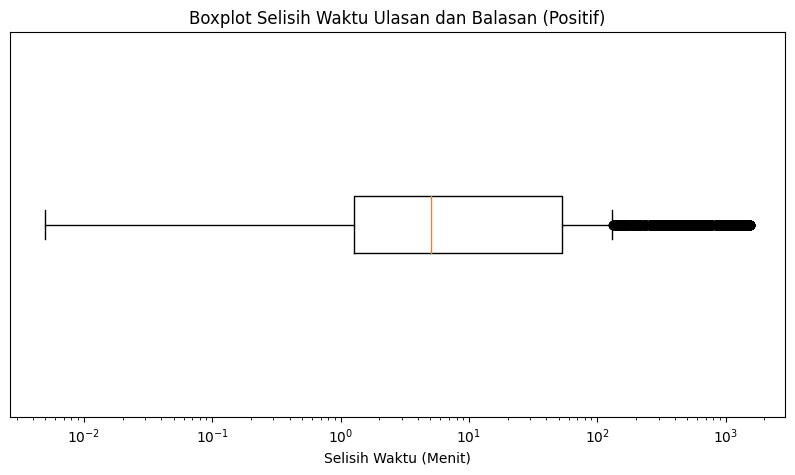

In [ ]:
import matplotlib.pyplot as plt

# Filter selisih waktu yang positif
positive_time_difference_seconds = time_difference_seconds[time_difference_seconds >= 0]
positive_time_difference_hours = positive_time_difference_seconds / 3600

# Plot boxplot selisih waktu yang positif dengan skala logaritmik pada sumbu x
plt.figure(figsize=(10, 5))
plt.boxplot(positive_time_difference_hours, vert=False)
plt.title('Boxplot Selisih Waktu Ulasan dan Balasan (Positif)')
plt.xlabel('Selisih Waktu (Menit)')
plt.xscale('log')  # Atur skala sumbu x menjadi logaritmik
plt.yticks([])
plt.show()

### Duplicated

In [ ]:
df_collected.groupby(df_collected.duplicated()).size()

False    22000
dtype: int64

### Content

In [ ]:
df_collected['review_len'] = df_collected['content'].astype(str).apply(len)
df_collected['word_count'] = df_collected['content'].apply(lambda x: len(str(x).split()))

array([[<Axes: title={'center': 'review_len'}>,
        <Axes: title={'center': 'word_count'}>]], dtype=object)

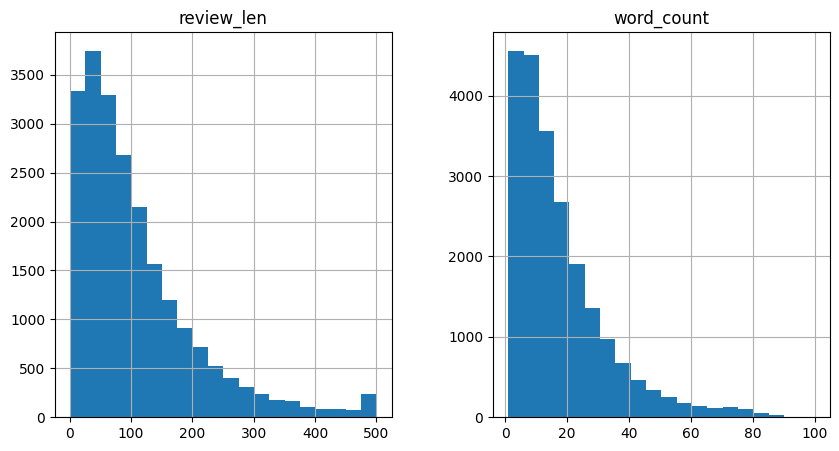

In [ ]:
df_collected[["review_len", "word_count"]].hist(bins=20, figsize=(10, 5))

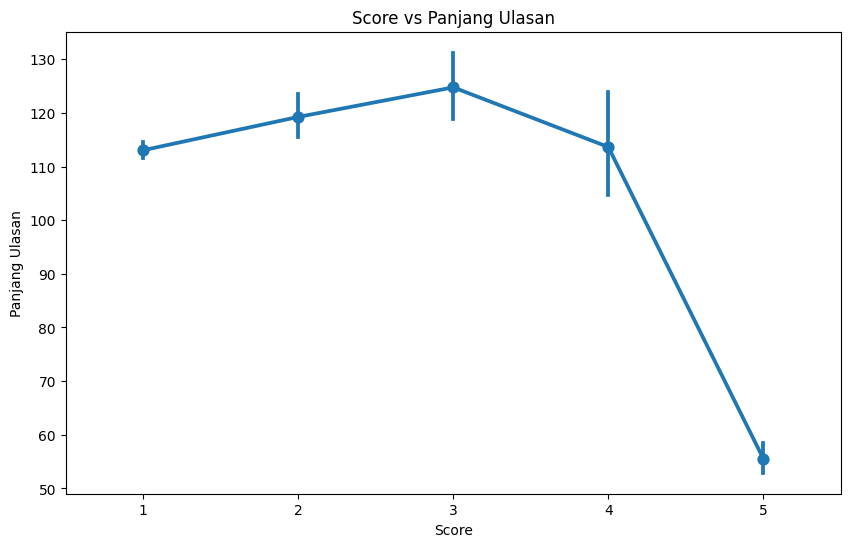

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.pointplot(x = "score", y = "review_len", data = df_collected)
plt.xlabel("Score")
plt.ylabel("Panjang Ulasan")
plt.title("Score vs Panjang Ulasan")
plt.show()

# Data Preparation

## Content

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
stop_factory = StopWordRemoverFactory()
sastrawi_sw = stop_factory.get_stop_words()

In [ ]:
df_prepared = df_collected.copy()

In [ ]:
kamus_alay = pd.read_csv("https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv")

In [ ]:
alay_dict = dict(zip(kamus_alay['slang'], kamus_alay['formal']))

In [ ]:
id_sw = pd.read_csv('https://raw.githubusercontent.com/masdevid/ID-Stopwords/master/id.stopwords.02.01.2016.txt', delimiter='\t', header=None)

In [ ]:
import re

def clean(text, more_sw=[], kamus=alay_dict):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = ' '.join(text.split())
    tokens = nltk.word_tokenize(text)
    tokens_mapped = [kamus.get(token, token) for token in tokens]
    stopwords = set(sastrawi_sw + more_sw + id_sw[0].tolist())
    filtered_tokens = [word for word in tokens_mapped if word not in stopwords]
    text = ' '.join(filtered_tokens)
    text = ' '.join(text.split())

    return text

### Cleaning: Loop 1

In [ ]:
df_prepared['content_cleaned'] = df_prepared['content'].apply(clean)

In [ ]:
df_prepared[['content','content_cleaned']]

,content,content_cleaned
0,Pengembalian dana tiket lama betul aplikasi in...,pengembalian dana tiket aplikasi uang nya nyan...
1,"Aduh tolong gimana ini ,mau jadi member basic ...",aduh member basic susahnya ampun pas klik lanj...
2,Good.,good
3,sangat mudah dan membantu,mudah membantu
4,Setiap habis top up harus nunggu lama kurang m...,habis top up menunggu memuaskan
...,...,...
21995,Saya kasih bintang 5 nih supaya di baca keluha...,kasih bintang 5 nih baca keluhannya aplikasi b...
21996,Aplikasi zampah.. Permintaan Time Out melulu !...,aplikasi zampah permintaan time out melulu bik...
21997,Saban hari tiap taon server down,saban server down
21998,Lemotnya,lemotnya


In [ ]:
freq_word = pd.DataFrame()
freq_word['word'] = df_prepared['content_cleaned'].str.split().explode().value_counts().index
freq_word['count'] = df_prepared['content_cleaned'].str.split().explode().value_counts().values

In [ ]:
freq_word[:75]

,word,count
0,aplikasi,6763
1,tiket,6708
2,nya,4063
3,kai,3477
4,update,3143
...,...,...
70,up,513
71,pay,510
72,hp,508
73,fitur,504


In [ ]:
freq_word[:75]['word'].to_list()

['aplikasi',
 'tiket',
 'nya',
 'kai',
 'update',
 'banget',
 'pesan',
 'pakai',
 'kereta',
 'susah',
 'masuk',
 'pembayaran',
 'lemot',
 'login',
 'apk',
 'versi',
 'bagus',
 'beli',
 'aplikasinya',
 'enggak',
 'muncul',
 'jadwal',
 'ribet',
 'kalo',
 'stasiun',
 'pas',
 'habis',
 'sih',
 'saldo',
 'bayar',
 'akun',
 'error',
 'bikin',
 'jelek',
 'eror',
 'bisa',
 'lokal',
 'gagal',
 'mohon',
 'perbaiki',
 'parah',
 'kali',
 'kayak',
 'jam',
 'data',
 'diperbaiki',
 'upgrade',
 'buruk',
 'buka',
 '1',
 'email',
 'daftar',
 'access',
 'mudah',
 'loading',
 'log',
 'deh',
 'mulu',
 'kursi',
 'mending',
 'out',
 'pemesanan',
 'nih',
 'coba',
 'kak',
 'bug',
 'menunggu',
 'tampilan',
 'kecewa',
 'orang',
 'up',
 'pay',
 'hp',
 'fitur',
 'terbaru']

In [ ]:
more_sw = ['aplikasi', 'nya', 'kai', 'banget', 'pakai', 'apk', 'aplikasinya', 'enggak', 'kalo', 'pas', 'habis', 'sih', 'bikin', 'bisa', 'mohon', 'kali', 'kayak', 'access', 'deh', 'mulu', 'mending', 'nih', 'coba', 'kak']

### Cleaning: Loop 2

In [ ]:
df_prepared['content_cleaned'] = df_prepared['content_cleaned'].apply(clean, more_sw=more_sw)

In [ ]:
df_prepared[['content','content_cleaned']]

,content,content_cleaned
0,Pengembalian dana tiket lama betul aplikasi in...,pengembalian dana tiket uang nyangkut balikin ...
1,"Aduh tolong gimana ini ,mau jadi member basic ...",aduh member basic susahnya ampun klik lanjutka...
2,Good.,good
3,sangat mudah dan membantu,mudah membantu
4,Setiap habis top up harus nunggu lama kurang m...,top up menunggu memuaskan
...,...,...
21995,Saya kasih bintang 5 nih supaya di baca keluha...,kasih bintang 5 baca keluhannya buka error tul...
21996,Aplikasi zampah.. Permintaan Time Out melulu !...,zampah permintaan time out melulu sekelas becus
21997,Saban hari tiap taon server down,saban server down
21998,Lemotnya,lemotnya


In [ ]:
freq_word = pd.DataFrame()
freq_word['word'] = df_prepared['content_cleaned'].str.split().explode().value_counts().index
freq_word['count'] = df_prepared['content_cleaned'].str.split().explode().value_counts().values

In [ ]:
freq_word[:75]

,word,count
0,tiket,6708
1,update,3143
2,pesan,2651
3,kereta,2043
4,susah,2014
...,...,...
70,qris,421
71,cari,419
72,ganti,419
73,kaipay,418


In [ ]:
freq_word[50:125]['word'].to_list()

['terbaru',
 'kasih',
 'top',
 '2',
 'ovo',
 'aneh',
 'membantu',
 'suka',
 'min',
 'langsung',
 'tiketnya',
 'otp',
 'ulang',
 'sistem',
 'lancar',
 'cek',
 'kota',
 'app',
 'sulit',
 'kode',
 'qris',
 'cari',
 'ganti',
 'kaipay',
 'antrian',
 'hilang',
 'menit',
 'jaringan',
 'cepat',
 'acces',
 'pilih',
 'tersedia',
 'enak',
 'bintang',
 'penumpang',
 'no',
 '00',
 'akses',
 'metode',
 'tau',
 'online',
 'payah',
 'time',
 'lihat',
 'basic',
 'dibuka',
 'kosong',
 'uang',
 'giliran',
 'isi',
 'mempersulit',
 'mempermudah',
 'kembalikan',
 'api',
 'menu',
 'aktivasi',
 'nomor',
 '3',
 'transaksi',
 'biar',
 'dana',
 'pembelian',
 'menyusahkan',
 'maaf',
 'member',
 'timeout',
 'eh',
 'tanggal',
 'suruh',
 'pilihan',
 'mencari',
 'nyaman',
 'diupdate',
 'bumn',
 'klik']

In [ ]:
more_sw.extend(['min', 'langsung', 'app', 'kalo', 'acces', 'no', '00', 'tau', 'biar', 'maap', 'eh'])

### Cleaning: Loop 3

In [ ]:
df_prepared['content_cleaned'] = df_prepared['content_cleaned'].apply(clean, more_sw=more_sw)

In [ ]:
df_prepared[['content','content_cleaned']]

,content,content_cleaned
0,Pengembalian dana tiket lama betul aplikasi in...,pengembalian dana tiket uang nyangkut balikin ...
1,"Aduh tolong gimana ini ,mau jadi member basic ...",aduh member basic susahnya ampun klik lanjutka...
2,Good.,good
3,sangat mudah dan membantu,mudah membantu
4,Setiap habis top up harus nunggu lama kurang m...,top up menunggu memuaskan
...,...,...
21995,Saya kasih bintang 5 nih supaya di baca keluha...,kasih bintang 5 baca keluhannya buka error tul...
21996,Aplikasi zampah.. Permintaan Time Out melulu !...,zampah permintaan time out melulu sekelas becus
21997,Saban hari tiap taon server down,saban server down
21998,Lemotnya,lemotnya


In [ ]:
freq_word = pd.DataFrame()
freq_word['word'] = df_prepared['content_cleaned'].str.split().explode().value_counts().index
freq_word['count'] = df_prepared['content_cleaned'].str.split().explode().value_counts().values

In [ ]:
freq_word[50:125]

,word,count
50,terbaru,500
51,kasih,495
52,top,494
53,2,484
54,ovo,481
...,...,...
120,semoga,258
121,tujuan,256
122,server,256
123,dipakai,255


In [ ]:
freq_word[100:175]['word'].to_list()

['3',
 'dana',
 'transaksi',
 'pembelian',
 'menyusahkan',
 'maaf',
 'member',
 'timeout',
 'tanggal',
 'suruh',
 'mencari',
 'pilihan',
 'nyaman',
 'diupdate',
 'bumn',
 'klik',
 'pembatalan',
 'pengguna',
 'e',
 'harga',
 'semoga',
 'tujuan',
 'server',
 'dipakai',
 'proses',
 'link',
 'gara',
 'keberangkatan',
 'pelayanan',
 'memasuki',
 'nama',
 'internet',
 'sinyal',
 'memudahkan',
 'sampah',
 'via',
 'mengecewakan',
 'logout',
 'terima',
 'berhasil',
 'lebaran',
 'bagusan',
 'sesuai',
 'kadang',
 'memilih',
 'perjalanan',
 'failed',
 'doang',
 'booking',
 'semenjak',
 'download',
 'kemarin',
 'gampang',
 'terimakasih',
 'salah',
 'kepotong',
 'duduk',
 'gangguan',
 'sumpah',
 'bingung',
 'gue',
 '5',
 'mantap',
 'hapus',
 'balikin',
 'wifi',
 'pencarian',
 'kagak',
 'tulisan',
 'tinggal',
 'memesan',
 'pt',
 'disuruh',
 'refund',
 'krl']

In [ ]:
more_sw.extend(['maaf', 'e', 'semoga', 'kadang', 'doang', 'semenjak', 'kagak'])

### Cleaning: Loop 4

In [ ]:
df_prepared['content_cleaned'] = df_prepared['content_cleaned'].apply(clean, more_sw=more_sw)

In [ ]:
df_prepared[['content','content_cleaned']]

,content,content_cleaned
0,Pengembalian dana tiket lama betul aplikasi in...,pengembalian dana tiket uang nyangkut balikin ...
1,"Aduh tolong gimana ini ,mau jadi member basic ...",aduh member basic susahnya ampun klik lanjutka...
2,Good.,good
3,sangat mudah dan membantu,mudah membantu
4,Setiap habis top up harus nunggu lama kurang m...,top up menunggu memuaskan
...,...,...
21995,Saya kasih bintang 5 nih supaya di baca keluha...,kasih bintang 5 baca keluhannya buka error tul...
21996,Aplikasi zampah.. Permintaan Time Out melulu !...,zampah permintaan time out melulu sekelas becus
21997,Saban hari tiap taon server down,saban server down
21998,Lemotnya,lemotnya


In [ ]:
freq_word = pd.DataFrame()
freq_word['word'] = df_prepared['content_cleaned'].str.split().explode().value_counts().index
freq_word['count'] = df_prepared['content_cleaned'].str.split().explode().value_counts().values

In [ ]:
freq_word[100:175]

,word,count
100,3,295
101,transaksi,289
102,dana,289
103,menyusahkan,288
104,pembelian,288
...,...,...
170,cuman,171
171,kendala,170
172,butuh,168
173,malam,167


In [ ]:
freq_word[150:225]['word'].to_list()

['duduk',
 'sumpah',
 'bingung',
 'gangguan',
 'gue',
 '5',
 'mantap',
 'hapus',
 'balikin',
 'wifi',
 'pencarian',
 'tulisan',
 'tinggal',
 'memesan',
 'pt',
 'disuruh',
 'refund',
 'krl',
 'ampun',
 'simple',
 'cuman',
 'kendala',
 'butuh',
 'malam',
 'pulsa',
 'by',
 'ui',
 'koneksi',
 'berkali',
 'enakan',
 'berkurang',
 'sekelas',
 'cs',
 'antri',
 'stabil',
 'perbarui',
 'oke',
 'simpel',
 'terdaftar',
 'masak',
 'lambat',
 'pelanggan',
 'user',
 'kerja',
 'nomer',
 'sistemnya',
 'tuh',
 'ubah',
 'menambah',
 'berangkat',
 'respon',
 'terpotong',
 'otomatis',
 'layanan',
 'lengkap',
 'kacau',
 'lelet',
 'kesini',
 'berat',
 'war',
 'loadingnya',
 'mesen',
 'request',
 'ngebug',
 'loket',
 'perbaikan',
 'h',
 'emosi',
 'verifikasi',
 'diperbarui',
 'topup',
 'boarding',
 'bermasalah',
 'keterangan',
 'apknya']

In [ ]:
more_sw.extend(['gue', 'cuman', 'by', 'oke', 'tuh', 'ada', 'h', 'apknya'])

### Cleaning: Loop 5

In [ ]:
df_prepared['content_cleaned'] = df_prepared['content_cleaned'].apply(clean, more_sw=more_sw)

In [ ]:
df_prepared[['content','content_cleaned']]

,content,content_cleaned
0,Pengembalian dana tiket lama betul aplikasi in...,pengembalian dana tiket uang nyangkut balikin ...
1,"Aduh tolong gimana ini ,mau jadi member basic ...",aduh member basic susahnya ampun klik lanjutka...
2,Good.,good
3,sangat mudah dan membantu,mudah membantu
4,Setiap habis top up harus nunggu lama kurang m...,top up menunggu memuaskan
...,...,...
21995,Saya kasih bintang 5 nih supaya di baca keluha...,kasih bintang 5 baca keluhannya buka error tul...
21996,Aplikasi zampah.. Permintaan Time Out melulu !...,zampah permintaan time out melulu sekelas becus
21997,Saban hari tiap taon server down,saban server down
21998,Lemotnya,lemotnya


In [ ]:
freq_word = pd.DataFrame()
freq_word['word'] = df_prepared['content_cleaned'].str.split().explode().value_counts().index
freq_word['count'] = df_prepared['content_cleaned'].str.split().explode().value_counts().values

In [ ]:
freq_word[150:225]

,word,count
150,duduk,196
151,sumpah,194
152,bingung,194
153,gangguan,194
154,5,191
...,...,...
220,benerin,122
221,tolol,120
222,saran,119
223,saldonya,118


#Topic Modelling: LDA

## Hyperparameter Tuning

In [ ]:
!pip install pyLDAvis==3.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.0-py2.py3-none-any.whl size=136698 sha256=4216cf53caefc87e3ba595d3558797638539b28f621b901ebf26a325b5eb5424
  Stored in directory: /root/.cache/pip/wheels/69/e9/d4/b9daca1097869dad1a5fc4062240e66541abff3dd5030129cf
Successfully built pyLDAvis


In [ ]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = df_prepared.content_cleaned.values.tolist()
data_words = list(sent_to_words(data))

In [ ]:
import gensim.corpora as corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

In [ ]:
max_coherence = {"min_freq":0, "coherence":0, "num_topics":0}

for min_freq in range(10,101,10):
  print(f"No Below: {max_coherence['min_freq']} | Coherence: {max_coherence['coherence']} | Num Topics: {max_coherence['num_topics']}")
  dictionary = corpora.Dictionary(data_words)
  dictionary.filter_extremes(no_below=min_freq)
  texts = data_words
  corpus = [dictionary.doc2bow(text) for text in texts]

  num_topics_range = range(3, 11)

  for num_topics in num_topics_range:
    # Membangun model LDA
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=3, random_state=2061)

    # Mencari Coherence Score
    cv_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=dictionary, coherence='c_v')
    cnpmi_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=dictionary, coherence='c_npmi')

    c_v = cv_model.get_coherence()
    c_npmi = cnpmi_model.get_coherence()

    avg = (c_v + c_npmi) / 2
    print(f"Num Topics: {num_topics} | c_v: {c_v}| c_npmi: {c_npmi} | avg: {avg}")

    if max_coherence["coherence"] < avg:
      max_coherence["coherence"] = avg
      max_coherence["min_freq"] = min_freq
      max_coherence["num_topics"] = num_topics
  print("\n")

No Below: 0 | Coherence: 0 | Num Topics: 0
Num Topics: 3 | c_v: 0.4856927897227583| c_npmi: 0.031686636476641 | avg: 0.2586897130996997
Num Topics: 4 | c_v: 0.4636154162111855| c_npmi: 0.02880526349275077 | avg: 0.24621033985196814
Num Topics: 5 | c_v: 0.4529559593229246| c_npmi: 0.016210144917329496 | avg: 0.23458305212012703
Num Topics: 6 | c_v: 0.4528025144984296| c_npmi: 0.02051939627146362 | avg: 0.2366609553849466
Num Topics: 7 | c_v: 0.46450169068832353| c_npmi: 0.020653218499028934 | avg: 0.24257745459367624
Num Topics: 8 | c_v: 0.4979366989117021| c_npmi: 0.02293835502222738 | avg: 0.26043752696696476
Num Topics: 9 | c_v: 0.45486734155741615| c_npmi: 0.010899045137915456 | avg: 0.2328831933476658
Num Topics: 10 | c_v: 0.4277538786311233| c_npmi: -0.010822221043898912 | avg: 0.2084658287936122


No Below: 10 | Coherence: 0.26043752696696476 | Num Topics: 8
Num Topics: 3 | c_v: 0.3970155291307407| c_npmi: 0.010788250266700718 | avg: 0.2039018896987207
Num Topics: 4 | c_v: 0.4765

In [ ]:
print(f"No Below: {max_coherence['min_freq']} | Coherence: {max_coherence['coherence']} | Num Topics: {max_coherence['num_topics']}")

No Below: 70 | Coherence: 0.29527126038058177 | Num Topics: 4


## Model Development

In [ ]:
dictionary = corpora.Dictionary(data_words)
dictionary.filter_extremes(no_below=70)
texts = data_words
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=4, passes=3, random_state=2061)

cv_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=dictionary, coherence='c_v')
cnpmi_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=dictionary, coherence='c_npmi')

c_v = cv_model.get_coherence()
c_npmi = cnpmi_model.get_coherence()

avg = (c_v + c_npmi) / 2

In [ ]:
print(f"Num Topics: 4 | c_v: {c_v}| c_npmi: {c_npmi} | avg: {avg}")

Num Topics: 4 | c_v: 0.5361503331386354| c_npmi: 0.054392187622528176 | avg: 0.29527126038058177


In [ ]:
# Mendapatkan topik dari model LDA
topics = lda_model.print_topics(num_topics=4)

# Mencetak setiap topik
for topic in topics:
    print("Topik {}: {}".format(topic[0], topic[1]))

Topik 0: 0.056*"lemot" + 0.053*"login" + 0.051*"update" + 0.047*"masuk" + 0.044*"susah" + 0.038*"akun" + 0.028*"email" + 0.025*"data" + 0.023*"upgrade" + 0.022*"daftar"
Topik 1: 0.058*"bagus" + 0.052*"versi" + 0.035*"update" + 0.033*"lemot" + 0.032*"buruk" + 0.032*"loading" + 0.021*"tampilan" + 0.019*"kasih" + 0.019*"terbaru" + 0.019*"jelek"
Topik 2: 0.098*"pembayaran" + 0.050*"bayar" + 0.038*"ribet" + 0.034*"saldo" + 0.032*"ovo" + 0.029*"link" + 0.026*"qris" + 0.025*"gagal" + 0.025*"tiket" + 0.024*"metode"
Topik 3: 0.162*"tiket" + 0.071*"pesan" + 0.059*"kereta" + 0.036*"beli" + 0.034*"muncul" + 0.033*"stasiun" + 0.033*"jadwal" + 0.025*"lokal" + 0.024*"error" + 0.019*"jam"


*   Topik 0: Akses Akun
*   Topik 1: Perbandingan Kualitas
*   Topik 2: Pembayaran
*   Topik 3: Pemesanan Tiket Kereta



In [ ]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


## Data Labeling

In [ ]:
tokenized_texts = df_prepared['content_cleaned'].apply(lambda x: x.split())
corpus_new = [dictionary.doc2bow(text) for text in tokenized_texts]

topics = [lda_model.get_document_topics(doc) for doc in corpus_new]
dominant_topics = [max(t, key=lambda x: x[1])[0] for t in topics]

df_prepared['dominant_topic'] = dominant_topics

# Data Analysis

## Topik Dominan

In [ ]:
df_prepared['dominant_topic'].value_counts().sort_index()

0    7202
1    5198
2    3600
3    6000
Name: dominant_topic, dtype: int64

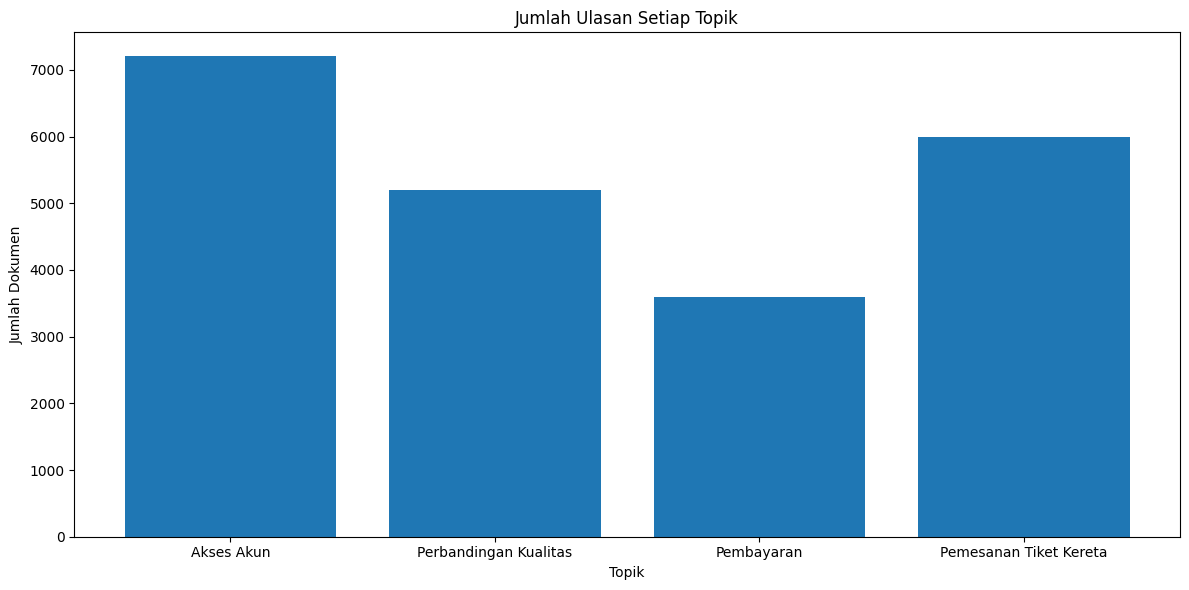

In [ ]:
import matplotlib.pyplot as plt

# Data
topics = ['Akses Akun', 'Perbandingan Kualitas', 'Pembayaran', 'Pemesanan Tiket Kereta']
counts = df_prepared['dominant_topic'].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(topics, counts)
plt.xlabel('Topik')
plt.ylabel('Jumlah Dokumen')
plt.title('Jumlah Ulasan Setiap Topik')
plt.xticks(rotation=360, ha='center')
plt.tight_layout()
plt.show()

In [ ]:
score_topic_0 = df_prepared[df_prepared['dominant_topic']==0]['score'].value_counts().values
score_topic_1 = df_prepared[df_prepared['dominant_topic']==1]['score'].value_counts().values
score_topic_2 = df_prepared[df_prepared['dominant_topic']==2]['score'].value_counts().values
score_topic_3 = df_prepared[df_prepared['dominant_topic']==3]['score'].value_counts().values

In [ ]:
df_score_topic_0 = pd.DataFrame({'score': sorted(df_prepared['score'].unique()), 'topic_0': score_topic_0})
df_score_topic_1 = pd.DataFrame({'score': sorted(df_prepared['score'].unique()), 'topic_1': score_topic_1})
df_score_topic_2 = pd.DataFrame({'score': sorted(df_prepared['score'].unique()), 'topic_2': score_topic_2})
df_score_topic_3 = pd.DataFrame({'score': sorted(df_prepared['score'].unique()), 'topic_3': score_topic_3})

In [ ]:
# Concatenate DataFrames
score_topic_concat = pd.merge(df_score_topic_0, df_score_topic_1, on='score', how='outer')
score_topic_concat = pd.merge(score_topic_concat, df_score_topic_2, on='score', how='outer')
score_topic_concat = pd.merge(score_topic_concat, df_score_topic_3, on='score', how='outer')

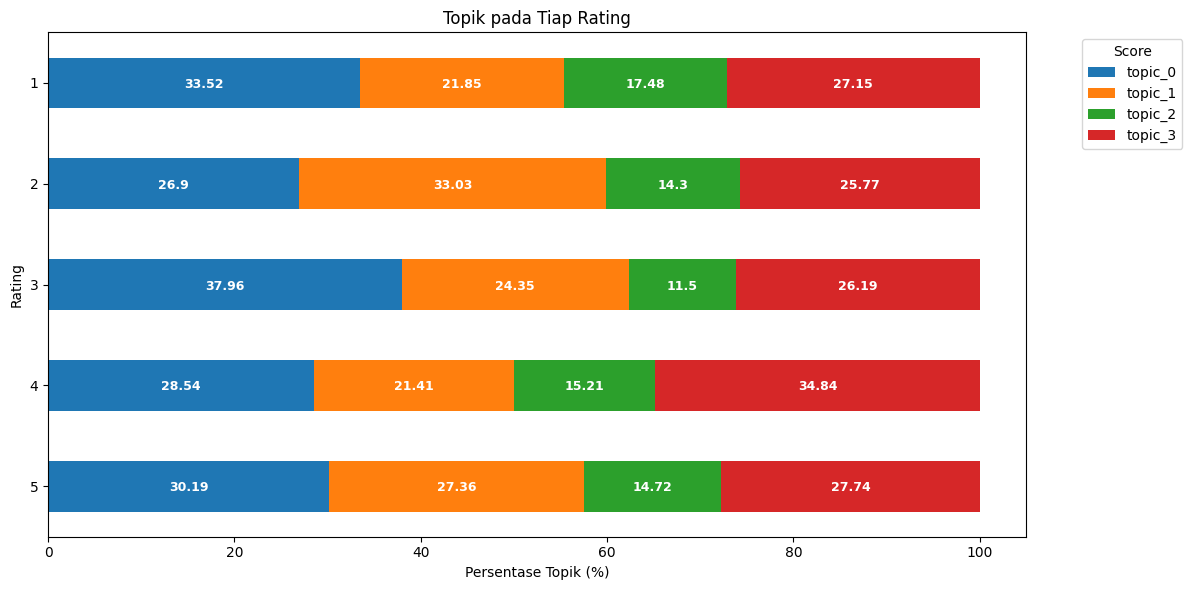

In [ ]:
df_score_topic = score_topic_concat.set_index('score')
top_score_topic_idx = df_score_topic.sum(axis=1).nlargest(10).index

top_score_topic = df_score_topic.loc[top_score_topic_idx]
top_score_topic = top_score_topic.div(top_score_topic.sum(axis=1), axis=0)
top_score_topic = top_score_topic.iloc[::-1].apply(lambda x: x *100)

# Membuat horizontal stacked bar chart yang dinormalisasi dengan urutan terbalik
fig, ax = plt.subplots(figsize=(12, 6))  # Mengatur ukuran gambar
top_score_topic.plot(kind='barh', stacked=True, ax=ax)

for bar in ax.patches:
  if round(bar.get_width(), 2) > 4:
    ax.text(
      y = bar.get_y() - 0.05 + bar.get_height() / 2,
      x= bar.get_width()/2 + bar.get_x(),
      s= round(bar.get_width(), 2),
      ha='center',
      color='w',
      weight='bold',
      size=9
    )

plt.title('Topik pada Tiap Rating')
plt.xlabel('Persentase Topik (%)')
plt.ylabel('Rating')
plt.legend(title='Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Unigram Word Cloud

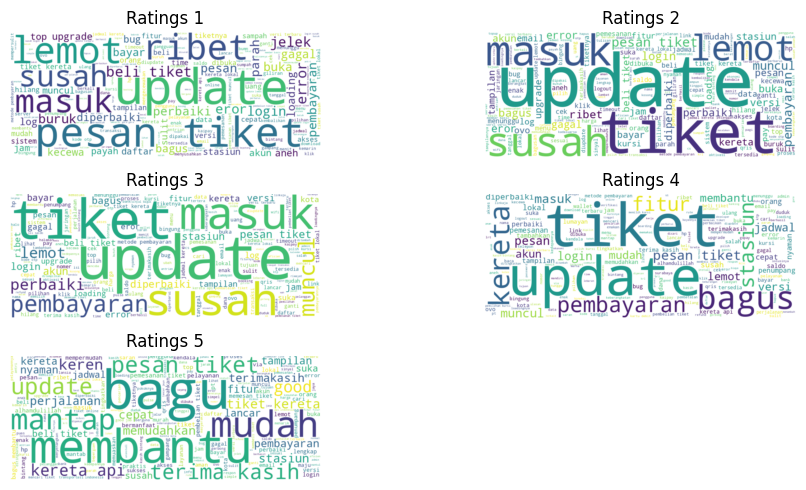

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

ratings = sorted(df_prepared['score'].unique())
num_rows = (len(ratings) + 1) // 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))

for i, rating in enumerate(ratings):
    df_ratings = df_prepared[df_prepared['score'] == rating]
    text = ' '.join(df_ratings['content_cleaned'])
    wordcloud = WordCloud(width=1000, height=400, background_color='white').generate(text)

    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(wordcloud, interpolation='bilinear')
    axes[row, col].set_title(f'Ratings {rating}')
    axes[row, col].axis('off')

for j in range(len(ratings), num_rows*num_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

## Kemunculan Bigram

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
bigram_1 = get_top_n_bigram(df_prepared[df_prepared['score']==1]['content_cleaned'], 10)
bigram_2 = get_top_n_bigram(df_prepared[df_prepared['score']==2]['content_cleaned'], 10)
bigram_3 = get_top_n_bigram(df_prepared[df_prepared['score']==3]['content_cleaned'], 10)
bigram_4 = get_top_n_bigram(df_prepared[df_prepared['score']==4]['content_cleaned'], 10)
bigram_5 = get_top_n_bigram(df_prepared[df_prepared['score']==5]['content_cleaned'], 10)

In [ ]:
df_bigram_1 = pd.DataFrame(bigram_1, columns=['bigram', "score_1"])
df_bigram_2 = pd.DataFrame(bigram_2, columns=['bigram', "score_2"])
df_bigram_3 = pd.DataFrame(bigram_3, columns=['bigram', "score_3"])
df_bigram_4 = pd.DataFrame(bigram_4, columns=['bigram', "score_4"])
df_bigram_5 = pd.DataFrame(bigram_5, columns=['bigram', "score_5"])

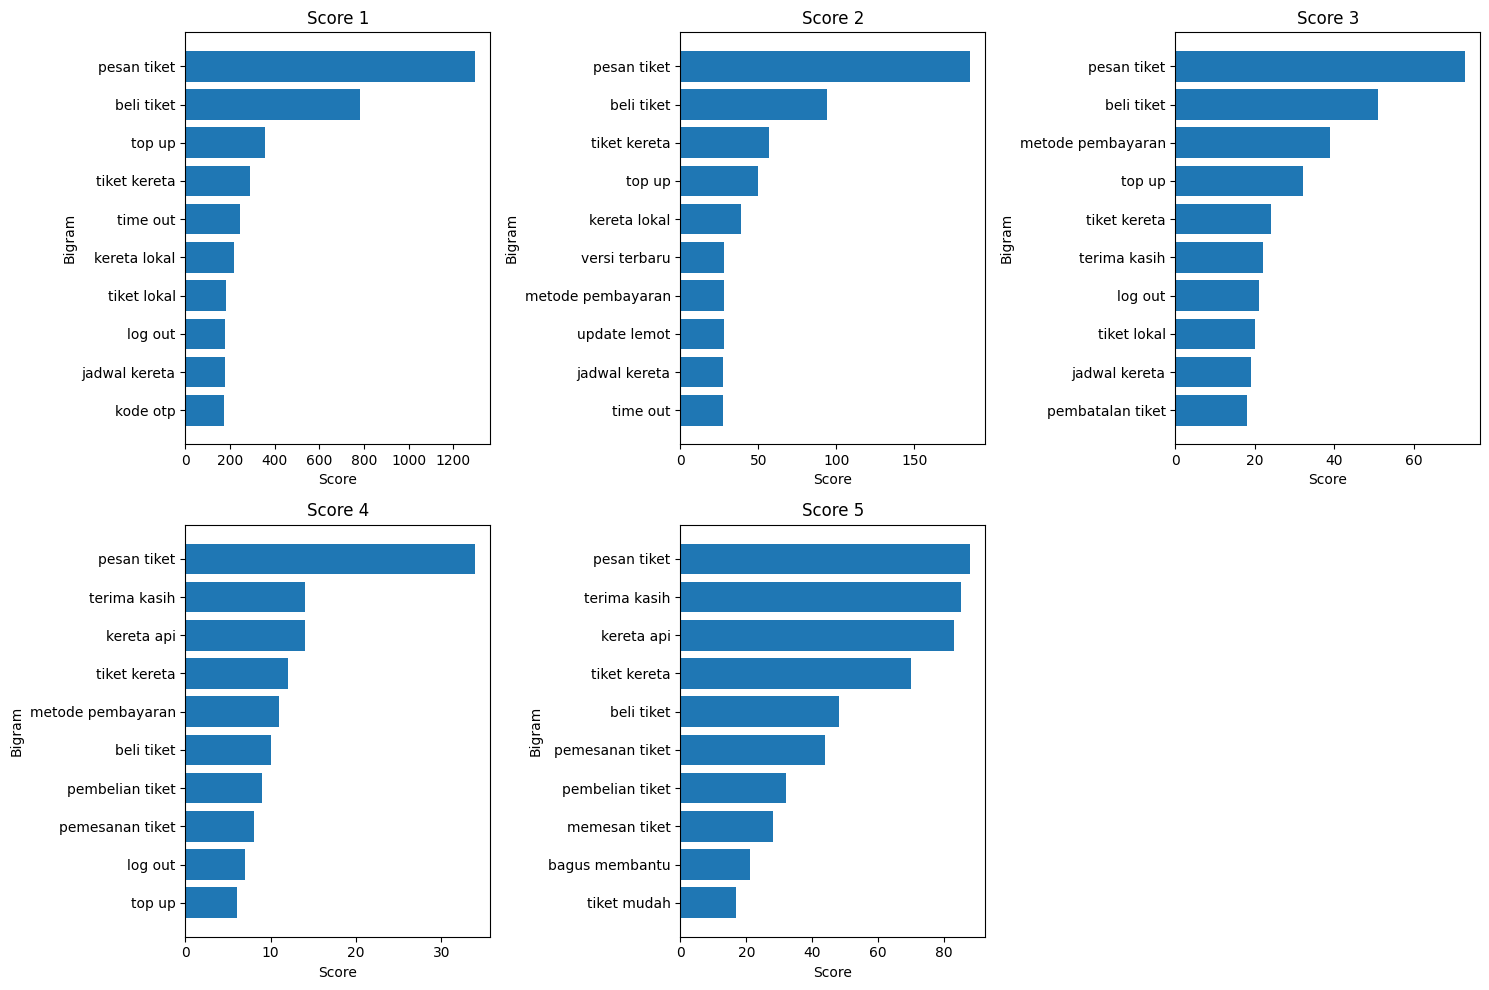

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plotting each DataFrame
dfs = [df_bigram_1, df_bigram_2, df_bigram_3, df_bigram_4, df_bigram_5]
for i, df in enumerate(dfs):
    row = i // 3
    col = i % 3
    df.sort_values(by=f'score_{i+1}', ascending=True, inplace=True)
    axs[row, col].barh(df['bigram'], df[f'score_{i+1}'])
    axs[row, col].set_title(f'Score {i+1}')
    axs[row, col].set_xlabel('Score')
    axs[row, col].set_ylabel('Bigram')

for i in range(len(dfs), len(axs.flat)):
    axs.flat[i].axis('off')

plt.tight_layout()
plt.show()